# Imports

In [2]:
from tqdm import tqdm
import joblib

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

from skimage import data, color, feature
from skimage.transform import resize, rescale

from PIL import Image

from utils import (
    non_max_suppression,
    sliding_window,
    detections_by_scale,
    detections_by_scale_2,
    evaluate_detections_by_scale,
    global_multiscale_detection,
    evaluate_detections_by_scale_2,
    global_multiscale_detection_2,
    evaluate_detections_at_scale,
    evaluate_detections_at_scale_2,
    detections_by_scale_2_max
)

# Clasificador

In [ ]:
# Cargar modelo entrenado
clf = joblib.load('../../modelos/modelos entrega kaggle 20250621/XGBoost_MEJOR_GLOBAL_pipeline.pkl') 


# Cargar standard scaler
#scaler = joblib.load('scaler.joblib')

# Cargar pca
pca = joblib.load('../../modelos/pca_20250621.pkl')

# Tamaño de las imagenes de entrenamiento
size = (64,64)

# Imagen de prueba

In [4]:
# Imagen de prueba
test_image = data.astronaut()
test_image = color.rgb2gray(test_image)
test_image = (test_image*255).astype(np.uint8)
test_image = rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]
test_image = rescale(test_image, 0.8)

In [18]:
test_image.shape

(128, 112)

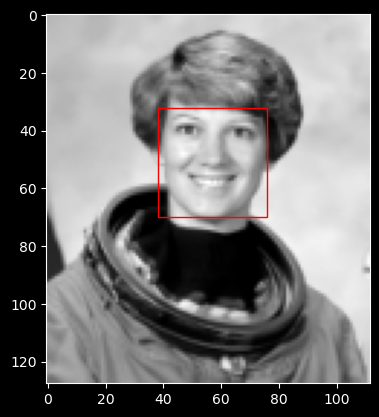

In [5]:
# Visualizamos la imagen
# Buscamos la escala de los rostros
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')

true_scale = 0.6
Ni, Nj = (int(true_scale * s) for s in size)

ax.add_patch(plt.Rectangle((38, 32), Nj, Ni, edgecolor='red', alpha=1, lw=1, facecolor='none'))
plt.show()

# Desempeño según umbrales

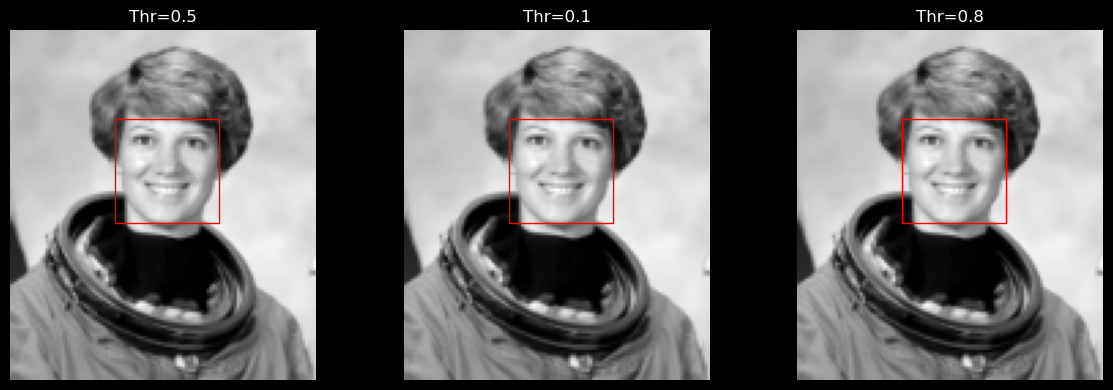

In [6]:
detecciones = evaluate_detections_at_scale_2(
    image=test_image,
    clf=clf,
#    scaler=scaler,
    pca=pca,
    scale=true_scale,
    thresholds=[0.5, 0.1, 0.8],
    patch_size=(64, 64),
    overlapThresh=0.1,
    plot=True
)

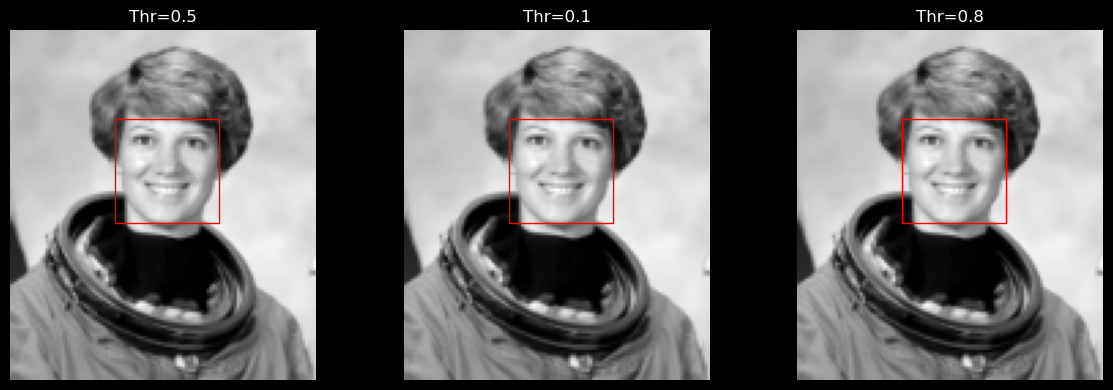

In [7]:
detecciones = evaluate_detections_at_scale_2(
    image=test_image,
    clf=clf,
#    scaler=scaler,
    pca=pca,
    scale=true_scale,
    thresholds=[0.5, 0.1, 0.8],
    patch_size=(64, 64),
    overlapThresh=0.1,
    plot=True
)

### Desempeño en varias escalas según umbral

In [8]:
test_scales = np.linspace(0.125, 0.9, 20)

raw_detections, detections = evaluate_detections_by_scale_2(
    test_image,
    test_scales,
    clf=clf,
    #scaler=scaler,
    pca=pca,
    thresholds=[0.5, 0.1, 0.8],
    patch_size=(64, 64),
    step=2,
    true_scale=true_scale,
    number_faces=1
)


 10%|█         | 2/20 [00:20<03:08, 10.47s/it]


KeyboardInterrupt: 

In [8]:
test_scales = np.linspace(0.125, 0.9, 20)

raw_detections, detections = detections_by_scale_2(
    test_image,
    test_scales,
    clf=clf,
    #scaler=scaler,
    pca=pca,
    thresholds=[0.8],
    size=(64, 64),
    step=2,
)


100%|██████████| 20/20 [00:44<00:00,  2.22s/it]


In [17]:
print(raw_detections)
print(raw_detections.shape)
print(raw_detections.reshape(20))
a = raw_detections.reshape(20)

[[ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 1]
 [ 4]
 [ 8]
 [13]
 [14]
 [17]
 [17]
 [18]
 [19]
 [19]
 [18]
 [17]
 [14]
 [ 5]
 [ 4]
 [ 0]]
(20, 1)
[ 0  0  0  0  1  4  8 13 14 17 17 18 19 19 18 17 14  5  4  0]


In [22]:
max_raw_detections = np.max(a) 
print(max_raw_detections)

19


In [23]:
# meq uedo con los indices de a que son mayores a 0 y son mayores o iguales que el anterior indice y que el siguiente
 
indices = np.where((a > 0) & (a > max_raw_detections*0.8) & (np.concatenate(([True], a[1:] >= a[:-1])) & np.concatenate((a[:-1] >= a[1:], [True]))))[0]
print(indices)

[ 9 12 13]


In [24]:
test_scales[indices]

array([0.49210526, 0.61447368, 0.65526316])

In [ ]:
# raw detection para treshold 0.8
raw_08 = raw_detections[:, 2]
# me quedo con el indice de raw_08 solamente si el anterior es menor o igual y el posterior es menor o igual y es mayor a 0
raw_08_indexes = np.array([i for i in range(1, len(raw_08)-1) if raw_08[i-1] <= raw_08[i] and raw_08[i+1] <= raw_08[i] and raw_08[i] > 0])

In [30]:
raw_08

array([ 0,  0,  0,  0,  1,  4,  8, 13, 14, 17, 17, 18, 19, 19, 18, 17, 14,
        5,  4,  0])

In [31]:
raw_08_indexes

array([ 1,  4,  8, 13, 14, 17, 17, 18, 19, 19, 18, 17, 14,  5,  4])

array([], shape=(0, 3), dtype=int64)

In [11]:
detections

array([[1, 3, 0],
       [1, 2, 0],
       [0, 2, 0],
       [0, 2, 0],
       [2, 4, 1],
       [2, 4, 1],
       [2, 4, 2],
       [2, 2, 2],
       [2, 2, 2],
       [2, 2, 2],
       [1, 1, 1],
       [1, 2, 1],
       [1, 1, 1],
       [1, 2, 1],
       [1, 2, 1],
       [1, 1, 1],
       [1, 2, 1],
       [1, 1, 1],
       [1, 2, 1],
       [1, 2, 0]])

# Detección global

Escalas: 100%|██████████| 20/20 [00:36<00:00,  1.83s/it]


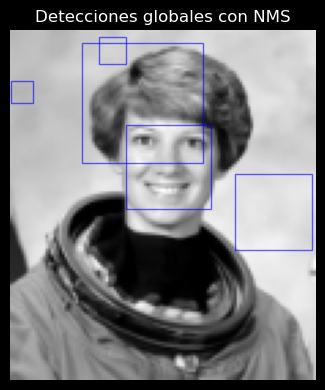

In [45]:
filtered_indices, filtered_sizes = global_multiscale_detection_2(
    test_image,
    clf=clf,
    #scaler=scaler,
    pca=pca,
    test_scales=np.linspace(0.125, 0.9, 20),
    patch_size=(64, 64),
    threshold=0.5,
    step=2,
    overlapThresh=0.3,
    plot=True
)

Escalas: 100%|██████████| 20/20 [00:37<00:00,  1.86s/it]


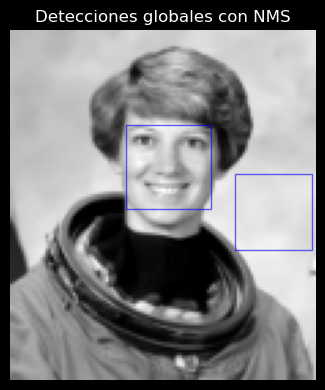

In [46]:
filtered_indices, filtered_sizes = global_multiscale_detection_2(
    test_image,
    clf=clf,
    #scaler=scaler,
    pca=pca,
    test_scales=np.linspace(0.125, 0.9, 20),
    patch_size=(64, 64),
    threshold=0.8,
    step=2,
    overlapThresh=0.1,
    plot=True
)

Escalas: 100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


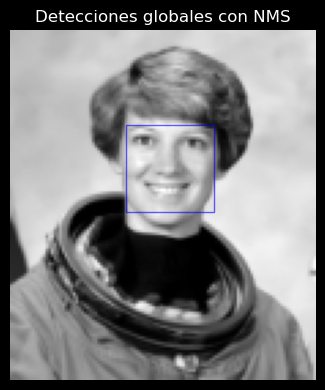

In [47]:
filtered_indices, filtered_sizes = global_multiscale_detection_2(
    test_image,
    clf=clf,
    #scaler=scaler,
    pca=pca,
    test_scales=np.linspace(0.5, 0.9, 10),
    patch_size=(64, 64),
    threshold=0.8,
    step=2,
    overlapThresh=0.1,
    plot=True
)

Escalas: 100%|██████████| 20/20 [00:55<00:00,  2.75s/it]


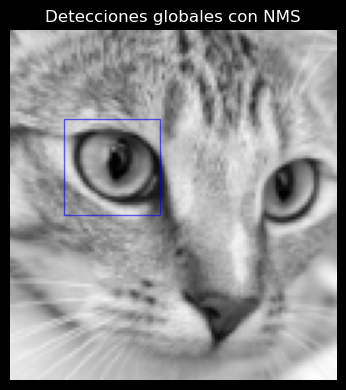

In [88]:
filtered_indices, filtered_sizes = global_multiscale_detection_2(
    test_image,
    clf=clf,
    #scaler=scaler,
    pca=pca,
    test_scales=np.linspace(0.5, 0.9, 20),
    #test_scales=[0.],
    patch_size=(64, 64),
    threshold=0.8,
    step=2,
    overlapThresh=0.1,
    plot=True
)

In [36]:
# Imagen de prueba
test_image = data.chelsea()
test_image = color.rgb2gray(test_image)
test_image = (test_image*255).astype(np.uint8)
test_image = rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]
test_image = rescale(test_image, 0.8)

Escalas: 100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


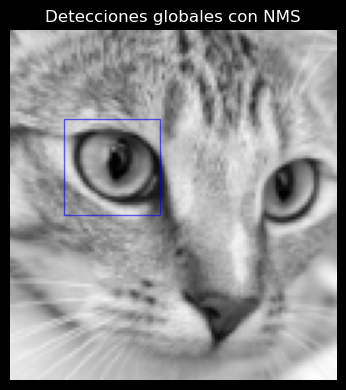

In [37]:
filtered_indices, filtered_sizes = global_multiscale_detection_2(
    test_image,
    clf=clf,
    #scaler=scaler,
    pca=pca,
    test_scales=np.linspace(0.5, 0.9, 20),
    #test_scales=[0.],
    patch_size=(64, 64),
    threshold=0.8,
    step=2,
    overlapThresh=0.1,
    plot=True
)

In [25]:
imagen = Image.open("../../imagenes_prueba/uruguay.jpg")
imagen_array = np.array(imagen)

In [82]:
imagen_array.shape  

(682, 1023, 3)

In [26]:
imagen_array = color.rgb2gray(imagen_array)  # ESTA LÍNEA NO ES NECESARIA
#imagen_array = (imagen_array*255).astype(np.uint8)
imagen_array = rescale(imagen_array, 0.5)
#imagen_array = imagen_array[:160, 40:180]
imagen_array = rescale(imagen_array, 0.8)

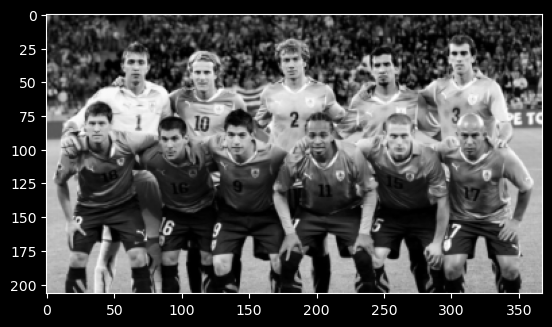

In [27]:
# visualizamos la imagen de imagen_array
fig, ax = plt.subplots()
ax.imshow(imagen_array, cmap='gray')
plt.show()

In [29]:
test_scales = np.linspace(0.125, 0.9, 20)

raw_detections, detections = detections_by_scale_2(
    imagen_array,
    test_scales,
    clf=clf,
    #scaler=scaler,
    pca=pca,
    thresholds=[0.8],
    size=(64, 64),
    step=2,
)

100%|██████████| 20/20 [05:38<00:00, 16.91s/it]


In [30]:
raw_detections

array([[ 7],
       [ 4],
       [ 7],
       [13],
       [21],
       [12],
       [15],
       [ 9],
       [ 7],
       [10],
       [14],
       [25],
       [36],
       [40],
       [32],
       [28],
       [17],
       [19],
       [23],
       [19]])

In [37]:
raw_detections_reshape = raw_detections.reshape(20)
max_raw_detections = np.max(raw_detections_reshape)
 
indices = np.where((raw_detections_reshape > 0) & (np.concatenate(([True], raw_detections_reshape[1:] >= raw_detections_reshape[:-1])) & np.concatenate((raw_detections_reshape[:-1] >= raw_detections_reshape[1:], [True]))))[0]
print(indices)

test_scales = np.linspace(0.125, 0.9, 20)[indices]

[ 0  4  6 13 18]


Escalas: 100%|██████████| 10/10 [04:18<00:00, 25.82s/it]


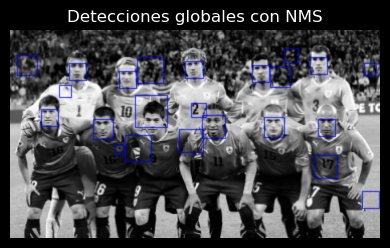

In [ ]:
filtered_indices, filtered_sizes = global_multiscale_detection_2(
    imagen_array,
    clf=clf,
    #scaler=scaler,
    pca=pca,
    test_scales=np.linspace(0.1, 0.5, 10),
    #test_scales=test_scales,
    patch_size=(64, 64),
    threshold=0.8,
    step=2,
    overlapThresh=0.1,
    plot=True
)


In [ ]:
filtered_indices, filtered_sizes = global_multiscale_detection_2(
    imagen_array,
    clf=clf,
    #scaler=scaler,
    pca=pca,
    test_scales=np.linspace(0.1, 0.5, 10),
    #test_scales=test_scales,
    patch_size=(64, 64),
    threshold=0.8,
    step=2,
    overlapThresh=0.1,
    plot=True
)


Escalas:  10%|█         | 1/10 [00:07<01:03,  7.03s/it]


KeyboardInterrupt: 

In [86]:
filtered_indices

array([[ 34,  42],
       [ 40, 364],
       [ 38, 148],
       [ 48, 306],
       [ 42,  76],
       [ 42, 126],
       [ 52, 236],
       [ 72,  32],
       [168, 140],
       [ 90, 164],
       [ 66, 130],
       [120, 134],
       [ 52, 274],
       [ 42, 192],
       [ 82, 190],
       [136,  10],
       [204, 260],
       [174, 294],
       [ 74, 322],
       [154, 140],
       [132, 160]])

In [53]:
imagen_2 = Image.open("../../imagenes_prueba/2894793.jpg")
imagen_array_2 = np.array(imagen_2)

In [54]:
imagen_array_2 = color.rgb2gray(imagen_array_2)  # ESTA LÍNEA NO ES NECESARIA
#imagen_array = (imagen_array*255).astype(np.uint8)
imagen_array_2 = rescale(imagen_array_2, 0.5)
#imagen_array = imagen_array[:160, 40:180]
imagen_array_2 = rescale(imagen_array_2, 0.8)

Escalas: 100%|██████████| 10/10 [05:02<00:00, 30.21s/it]


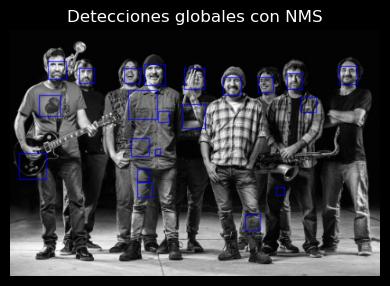

In [55]:
filtered_indices, filtered_sizes = global_multiscale_detection_2(
    imagen_array_2,
    clf=clf,
    #scaler=scaler,
    pca=pca,
    test_scales=np.linspace(0.1, 0.5, 10),
    #test_scales=test_scales,
    patch_size=(64, 64),
    threshold=0.8,
    step=2,
    overlapThresh=0.1,
    plot=True
)
